<a href="https://colab.research.google.com/github/DavidVollendroff/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 


In [0]:
def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate=1):
  # probability_of_actually_being_drunk = probability they were drunk and detected as drunk/probability they were drunk and detected as drunk PLUS THE PROBABILITY that they were not drunk and were falsely identified as DRUNK
  prob_actually_drunk = prob_drunk_prior*true_positive_rate/(prob_drunk_prior + false_positive_rate*(1-prob_drunk_prior))
  return prob_actually_drunk

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?

In [85]:
prob_drunk_prior = 1/1000 # prior belief
false_positive_rate = 0.08
true_positive_rate = 1
prob_drunk_given_positive(prob_drunk_prior, false_positive_rate)

0.012357884330202669

 - What is the probability that a person is drunk after two positive breathalyzer tests?


In [86]:
prob_drunk_given_1_positive_test = prob_drunk_given_positive(prob_drunk_prior, false_positive_rate) # updated prior belief
prob_drunk_given_positive(prob_drunk_given_1_positive_test, false_positive_rate) # new probability in light of updated prior

0.13525210993291495

 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

In [122]:
prob_drunk_prior = 1/1000 # prior belief
false_positive_rate = 0.08
num_tests = 0
desired_acc = 0.95
while prob_drunk_prior < desired_acc:
  num_tests += 1
  prob_drunk_prior = prob_drunk_given_positive(prob_drunk_prior, false_positive_rate)
print('{} tests were required to achieve probability' \
      ' >= {}% given these parameters'.format(num_tests, desired_acc*100))

0.012357884330202669
0.13525210993291495
0.6615996951348605
0.9606895076105054
4 tests were required to achieve probability >= 95.0% given these parameters


### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)


In [43]:
# bringing in data we've tested in other ways
import pandas as pd
from scipy import stats

column_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

df = pd.read_csv(data_url, header=None, na_values="?", names=column_headers)
df = df.replace({'y':1, 'n': 0})
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
import numpy as np

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = np.std(data, ddof=1)/np.sqrt(n)
  moe = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return ( mean - moe, mean, mean + moe)

In [0]:
sample_data = df[~df['water-project'].isnull()]['water-project']

In [48]:
# using the frequentist methods previously explored
confidence_interval(sample_data, confidence=0.95)

(0.45384081311663604, 0.5038759689922481, 0.5539111248678601)

In [0]:
from scipy.stats import bayes_mvs

In [50]:
bayes_mvs(sample_data, alpha=0.95)

(Mean(statistic=0.5038759689922481, minmax=(0.45384081311663604, 0.5539111248678601)),
 Variance(statistic=0.25193798449612403, minmax=(0.21871681013483255, 0.2901214855256391)),
 Std_dev(statistic=0.5016075698129333, minmax=(0.46767169054244934, 0.5386292653817086)))

In [66]:
thing = bayes_mvs(sample_data, alpha=0.95)
thing[0][0]

0.5038759689922481

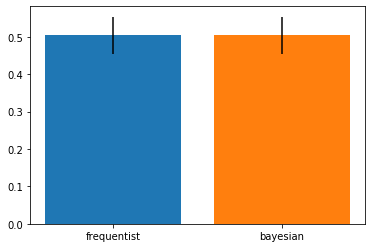

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

frequentist = confidence_interval(sample_data, confidence=0.95)
bayesian = bayes_mvs(sample_data, alpha=0.95)

ax.bar(x='frequentist',height=frequentist[1], yerr=frequentist[1]-frequentist[0])
ax.bar(x='bayesian',height=bayesian[0][0], yerr=bayesian[0][0] - bayesian[0][1][0])

plt.show()

In [89]:
df['party']

0      republican
1      republican
2        democrat
3        democrat
4        democrat
          ...    
430    republican
431      democrat
432    republican
433    republican
434    republican
Name: party, Length: 435, dtype: object

These didn't end up being different, so I'll write a function that compares these for all columns of this dataframe.

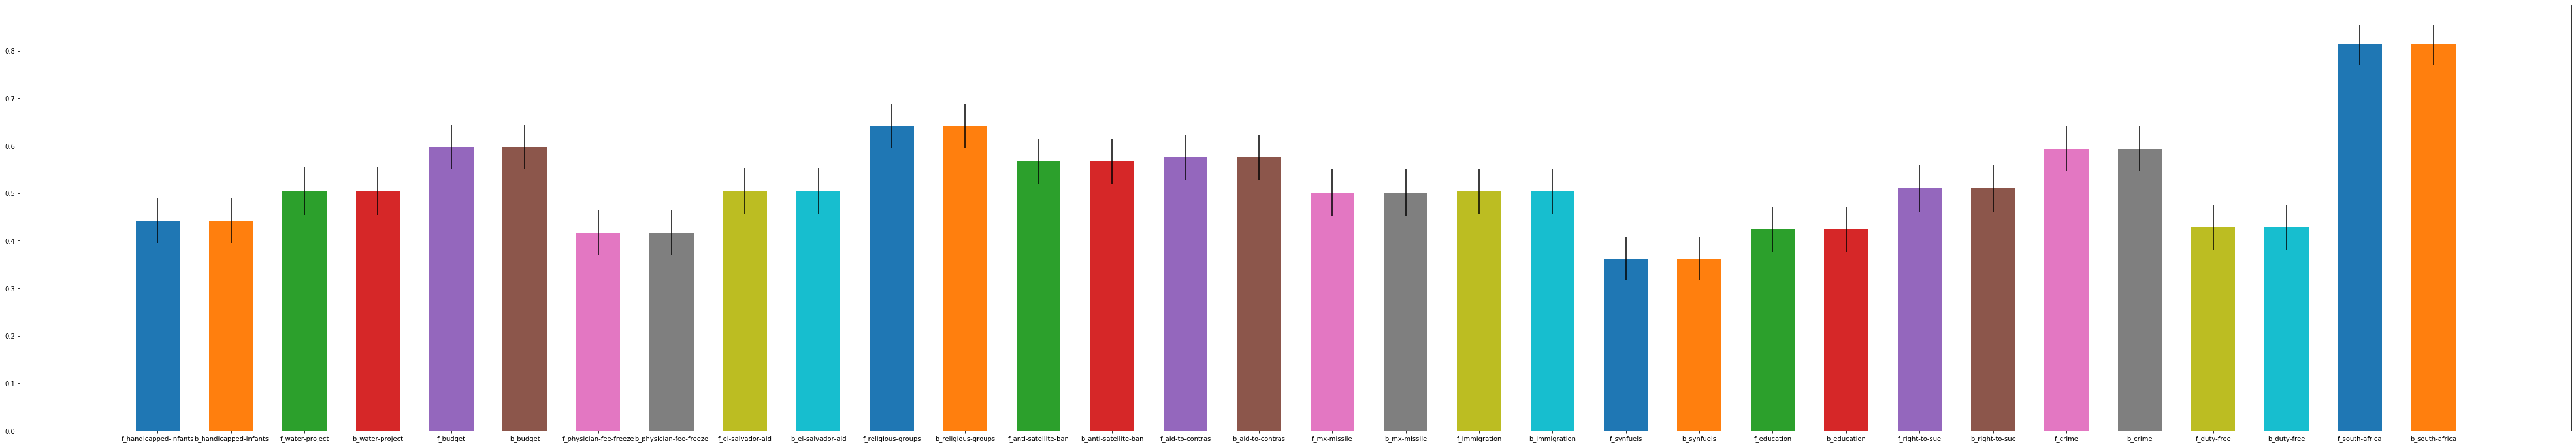

In [116]:
def compare_stuff(dataframe):
  dataframe = dataframe.drop(['party'], axis=1)
  fig, ax = plt.subplots()
  plt.rcParams['figure.figsize'] = [70, 12]
  
  for column in dataframe.columns:
    sample_data = df[~df[column].isnull()][column]
    frequentist = confidence_interval(sample_data, confidence=0.95)
    bayesian = bayes_mvs(sample_data, alpha=0.95)

    ax.bar(x='f_'+ column, height=frequentist[1], yerr=frequentist[1] - frequentist[0], width=0.6)
    ax.bar(x='b_'+ column, height=bayesian[0][0], yerr=bayesian[0][0] - bayesian[0][1][0], width=0.6)
  
  plt.show()


compare_stuff(df)

In [121]:
df.isnull().sum()

party                     0
handicapped-infants      12
water-project            48
budget                   11
physician-fee-freeze     11
el-salvador-aid          15
religious-groups         11
anti-satellite-ban       14
aid-to-contras           15
mx-missile               22
immigration               7
synfuels                 21
education                31
right-to-sue             25
crime                    17
duty-free                28
south-africa            104
dtype: int64

Upon reflection it makes sense that the difference seen for each different issue is of the same negligible magnitude. The number of votes cast on each is at least 330. It seems that such a sample size was enough for the frequentist and bayesian approaches to practically converge. The documentation in SciPy references an article describing the derivation of the formula used. Something called "Jeffrey's" prior is used. It seems like the way priors are determined is beyond the scope of this course and perhaps not worth troubling myself over at this time. I'll revisit this comparison again, assuming I remember to, at some point when I'm working with a smaller dataset.

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).


Bayesian statistics seeks to use access to prior knowledge and assumptions to make assessments whenever we don't have the luxury of considering a large quantity of data. Frequentist statistics rely only on the particular data we have on hand without assumptions.

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!